In [47]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [49]:
#creating one DataFrame for each selection method
#random_df = pd.DataFrame(all_generations[0])
#ranked_df = pd.DataFrame(all_generations[1])
#wheel_df = pd.DataFrame(all_generations[2])
#concatenating all dataframes (same dimensionality)
generations_df = pd.DataFrame(all_generations)
#checking the results
generations_df.sample(5)

,radius,generation,fitness,selection_type,gen_size
426749,2.235294,18,0.017171,Wheel Selection,40
10853,28.235294,185,0.000200,Random Selection,10
46881,7.529412,62,0.002746,Random Selection,30
30799,2.470588,189,0.015965,Random Selection,20
328529,2.117647,76,0.017696,Wheel Selection,20


In [50]:
#Sample Statistics
generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           500.0  15.547765  8.563465  0.235294  15.470588   
                 1           500.0  15.501412  8.411326  0.117647  15.470588   
                 2           500.0  15.183765  8.704074  0.117647  15.705882   
                 3           500.0  14.484471  8.853451  0.117647  15.000000   
                 4           500.0  14.589176  8.417519  0.117647  15.117647   
...                            ...        ...       ...       ...        ...   
Wheel Selection  295         500.0   1.748235  0.300713  1.294118   1.764706   
                 296         500.0   1.748235  0.300713  1.294118   1.764706   
                 297         500.0   1.748235  0.300713  1.294118   1.764706   
                 298         500.0   1.748235  0.300713  1.294118   1.764706   
                 299         500.0   1.748235  0.300713  1.294118   1.764706   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000   500.0  0.002733  0.004678  0.000177   
                 1           30.000000   500.0  0.002643  0.004530  0.000177   
                 2           29.882353   500.0  0.003071  0.005063  0.000178   
                 3           29.529412   500.0  0.003388  0.005098  0.000182   
                 4           29.882353   500.0  0.002896  0.004534  0.000178   
...                                ...     ...       ...       ...       ...   
Wheel Selection  295          2.352941   500.0  0.018157  0.000529  0.016588   
                 296          2.352941   500.0  0.018157  0.000529  0.016588   
                 297          2.352941   500.0  0.018157  0.000529  0.016588   
                 298          2.352941   500.0  0.018157  0.000529  0.016588   
                 299          2.352941   500.0  0.018157  0.000529  0.016588   

                                                gen_size                   \
                                  50%       max    count  mean        std   
selection_type   generation                                                 
Random Selection 0           0.000663  0.018701    500.0  30.0  10.010015   
                 1           0.000663  0.018701    500.0  30.0  10.010015   
                 2           0.000644  0.018701    500.0  30.0  10.010015   
                 3           0.000705  0.018701    500.0  30.0  10.010015   
                 4           0.000695  0.018701    500.0  30.0  10.010015   
...                               ...       ...      ...   ...        ...   
Wheel Selection  295         0.018323  0.018701    500.0  30.0  10.010015   
                 296         0.018323  0.018701    500.0  30.0  10.010015   
                 297         0.018323  0.018701    500.0  30.0  10.010015   
                 298         0.018323  0.018701    500.0  30.0  10.010015   
                 299         0.018323  0.018701    500.0  30.0  10.010015   

                                               
                              min   50%   max  
selection_type   generation                    
Random Selection 0           10.0  30.0  40.0  
                 1           10.0  30.0  40.0  
                 2           10.0  30.0  40.0  
                 3           10.0  30.0  40.0  
                 4           10.0  30.0  40.0  
...                           ...   ...   ...  
Wheel Selection  295         10.0  30.0  40.0  
                 296         10.0  30.0  40.0  
                 297         10.0  30.0  40.0  
                 298         10.0  30.0  40.0  
                 299         10.0  30.0  40.0  

[900 rows x 18 columns]

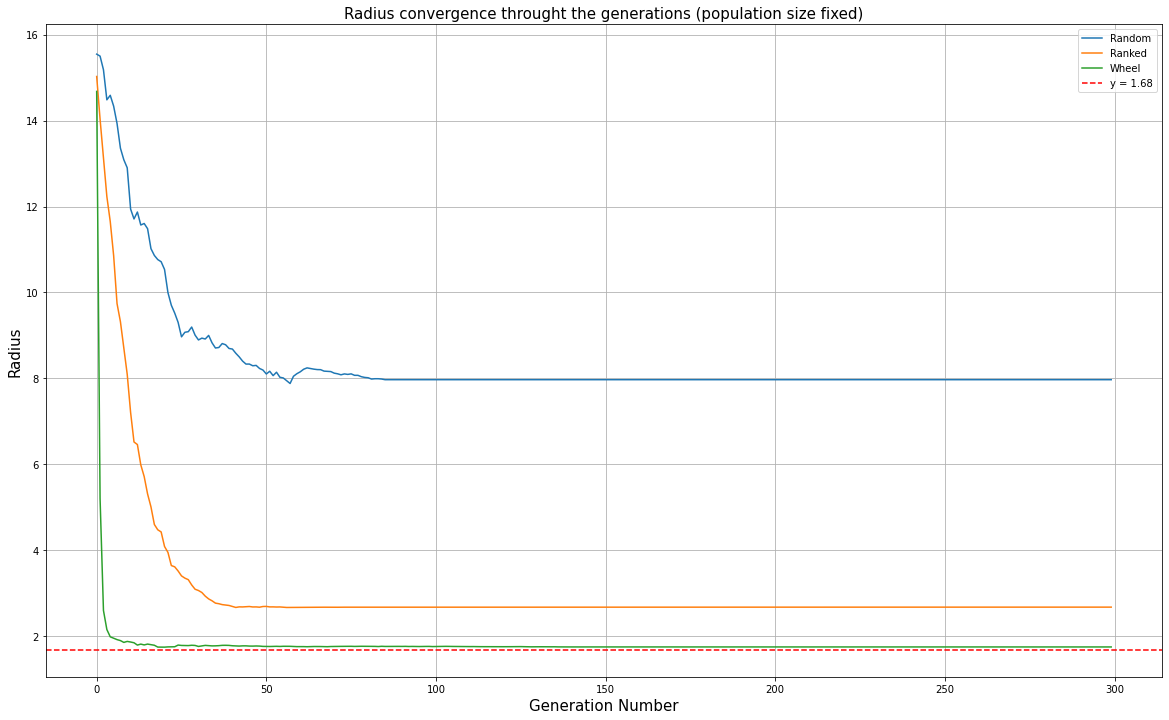

In [51]:
grouped = generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

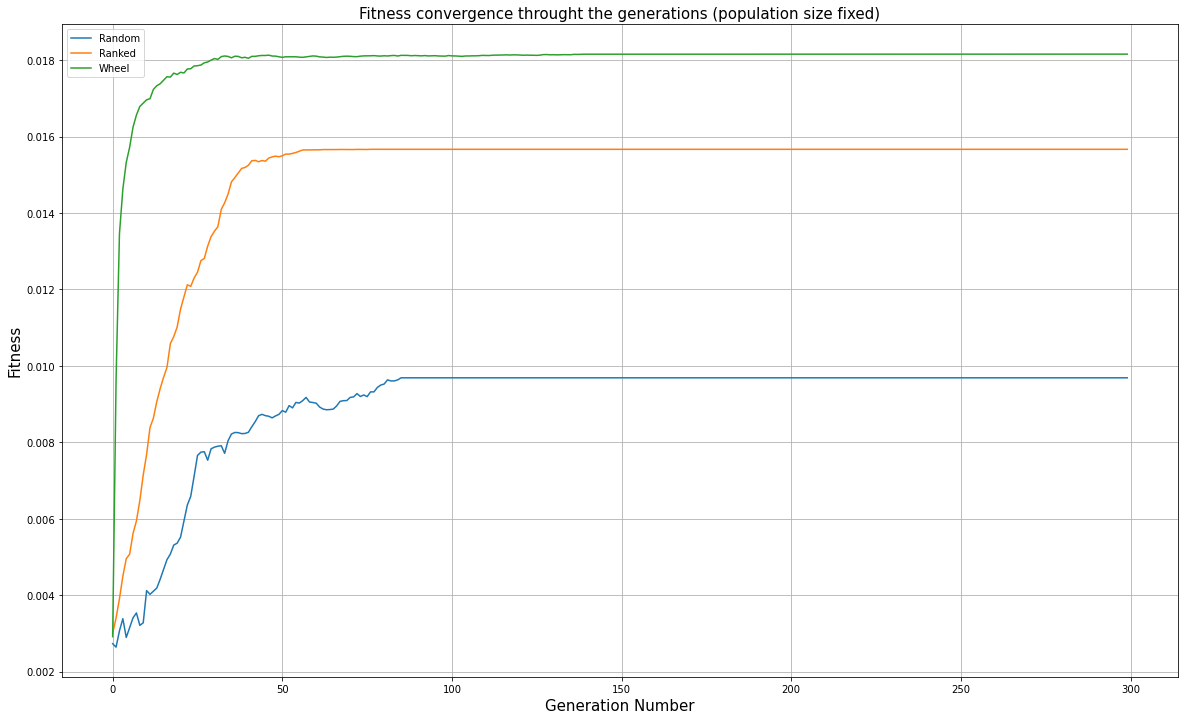

In [52]:
grouped = generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()

plt.show()